'''
<br><br>
@Author: Shivraj Yelave<br>
@Date: 3-10-24<br>
@Last modified by: Shivraj Yelave<br>
@Last modified time: <br>
@Title: Logistic Regression to Predict Subscription to Term Deposit<br>
<br>
'''


### Importing Libraries

In [55]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats


### Load Dataset

In [56]:
# Load the dataset
url = 'https://drive.google.com/uc?id=1E0EURgsF3L9Bt5hnOalE0d4Tw9mIOgTn'  # Change the link format for direct access
df = pd.read_csv(url, sep=';')  # Adjust separator if needed

# Display the first few rows of the DataFrame
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### Analize dataset

In [57]:
# Check for missing values in the features and target
print(df.isnull().sum())
print(df.describe())
print(df.info())


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  45

### Check for Outliers and Remove it

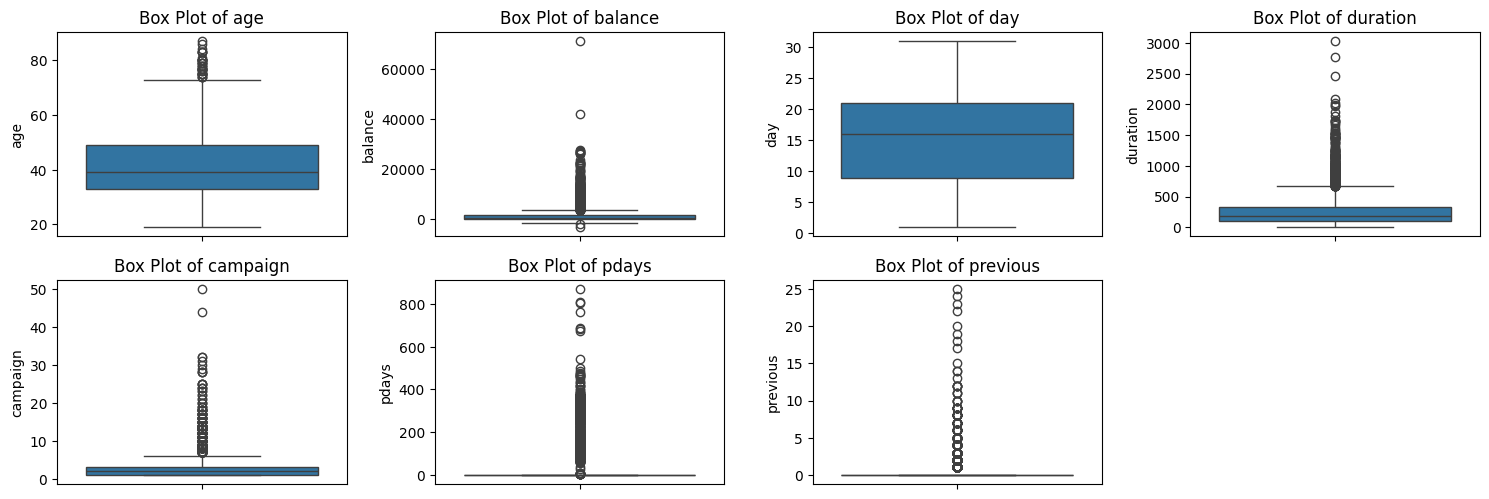

In [58]:
# Select only numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Visualizing the initial data with box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()


In [59]:

# Removing outliers using IQR for numerical columns
Q1 = df[num_columns].quantile(0.25)
Q3 = df[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtering the data to remove outliers
df_filtered = df[~((df[num_columns] < (Q1 - 1.5 * IQR)) | (df[num_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display the shape of the original and filtered data
print(f'Original data shape: {df.shape}')
print(f'Filtered data shape: {df_filtered.shape}')


Original data shape: (4521, 17)
Filtered data shape: (2803, 17)


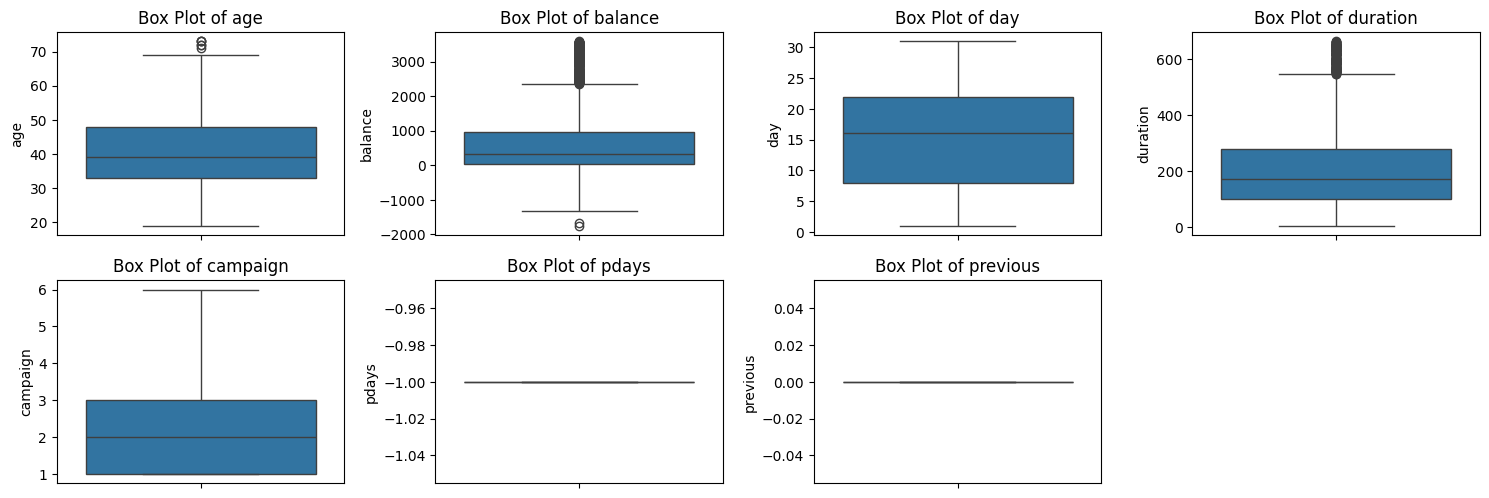

In [60]:
# Select only numerical columns
num_columns = df_filtered.select_dtypes(include=[np.number]).columns.tolist()

# Visualizing the initial data with box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df_filtered[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()


### Handle Catogircal data

In [61]:
# Encoding categorical variables
label_encoders = {}
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for column in categorical_columns:
    le = LabelEncoder()
    df_filtered.loc[:, column] = le.fit_transform(df_filtered[column])  # Using .loc to avoid SettingWithCopyWarning
    label_encoders[column] = le  # Store the encoder for potential inverse transformation later


### Split data in X and Y

In [62]:
# Encoding the target variable 'y' and keeping only numerical features
y = df_filtered['y'].map({'yes': 1, 'no': 0})  # Target variable (convert to binary)
X = df_filtered.drop(columns=['y'])  # Drop the target variable column
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,0
7,39,9,1,1,0,147,1,0,0,6,8,151,2,-1,0,0
8,41,2,1,2,0,221,1,0,2,14,8,57,2,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4510,36,9,0,1,0,566,1,0,2,20,8,129,2,-1,0,0
4512,40,1,1,1,0,1100,1,0,2,29,8,660,2,-1,0,0
4513,49,1,1,1,0,322,0,0,0,14,1,356,2,-1,0,0
4515,32,7,2,1,0,473,1,0,0,7,5,624,5,-1,0,0


### Check Corelation

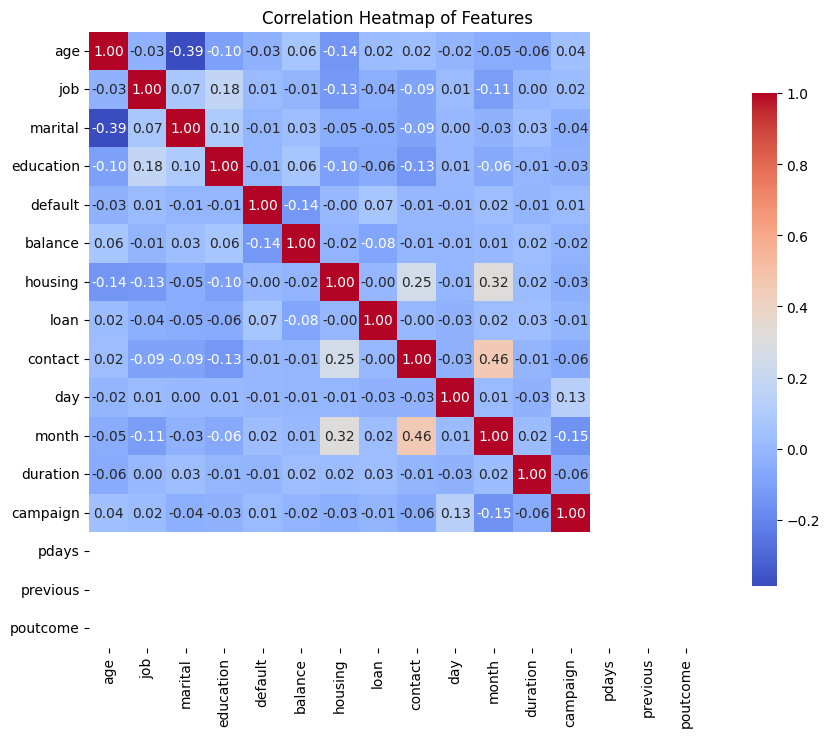

In [63]:
# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Features')
plt.show()

### Spit for Train Test

In [64]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Selection

In [65]:
# Creating and training the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)

### Model Evalution

Accuracy: 0.9554367201426025
Confusion Matrix:
 [[532   1]
 [ 24   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       533
           1       0.80      0.14      0.24        28

    accuracy                           0.96       561
   macro avg       0.88      0.57      0.61       561
weighted avg       0.95      0.96      0.94       561



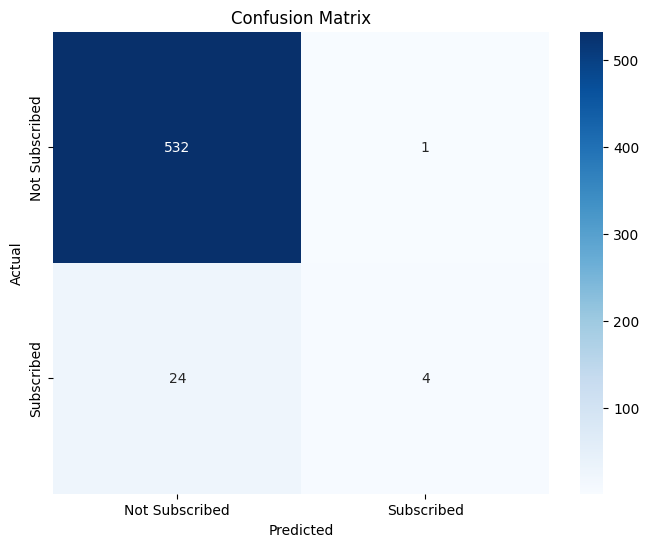

In [66]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()